In [1]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
import ccdproc as ccdp
from matplotlib import rc
from datetime import datetime
from astropy.nddata import CCDData

phot_tutorial_dir = '/Users/palladl2/Desktop/projects/phot-tutorials/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [2]:
# plotting defaults
# Use custom style for larger fonts and figures

plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [3]:
# define directories
data_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/Imaging/'
reduced_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/'

In [4]:
# define the trimsec for python (i.e. not for the fits header)
r0 = 0
r1 = 2048
c0 = 54
c1 = 2101

In [5]:
# get V-band filenames

nfiles = 7 # number of files in a sequence
nlow   = 43  # the exposure number for the first file 

skyflats_files = [reduced_dir+'a'+str(i).zfill(3)+'.fits' for i in np.arange(nfiles)+nlow]

hdus = [fits.open(file) for file in skyflats_files]
hdrs = [hdu[0].header for hdu in hdus]
skyflats = [hdu[0].data for hdu in hdus]

# read in the hdus, hdrs, data
# use list comprehension

# loop over the hdus or hdrs
    # add IMAGETYP, BIASSEC, TRIMSEC, FILTER
    # (I used 'skyflat' for my image type, if you use something else you'll need edit later code)
    # write out the hdu to the original fits file

In [6]:
#print(hdrs) #confirmed I have not added IMAGETYP, BIASSEC, TRIMSEC, or FILTER to the flats

In [7]:
for i in range(np.size(hdus)):
    print(i) # place holder for loop
    
    hdrs[i]['BIASSEC'] = '[0:2048,2102:2200]'
    hdrs[i]['TRIMSEC'] = '[0:2048,55:2102]'
    hdrs[i]['FILTER'] = "V"
    hdrs[i]['IMAGETYP'] = "skyflat"
    hdus[i].writeto(skyflats_files[i], overwrite = True)
    
del hdus
del hdrs

0
1
2
3
4
5
6


In [8]:
# put all of the fits files in an image collection
# this is just CCDPROC's way of storing information for groups of fits images
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='a*.fits') 

# if you've done the overscan, trim, and bias subtraction, use only those files
# imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='*otz.fits') # just read in the bias-subtracted images

In [9]:
# select all the flats
# you won't need these lines now, but they're handy
flat_files = imgs.files_filtered(imagetyp='skyflat',include_path=True)
bands = imgs.filter(imagetyp='skyflat').summary['filter'].data.data # makes a set of all filters
band = set(imgs.filter(imagetyp='skyflat').summary['filter'].data.data) # unique filter names

# isolate the v-band flats
# you do need this
v_files = imgs.files_filtered(imagetyp='skyflat',filter='V',include_path=True)
v_files

['/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a043.fits',
 '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a044.fits',
 '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a045.fits',
 '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a046.fits',
 '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a047.fits',
 '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a048.fits',
 '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a049.fits']

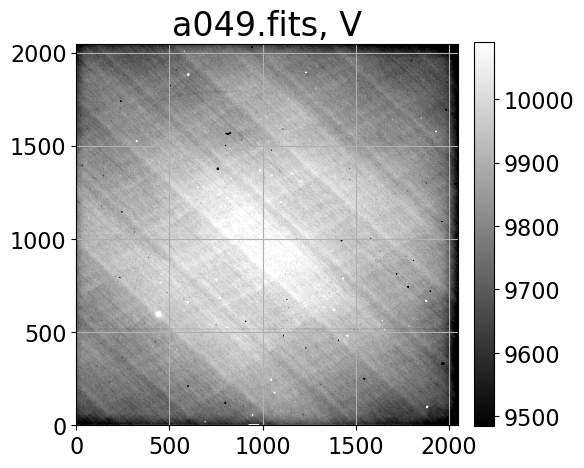

In [10]:
# here is how you would plot one flat
# you should edit this to do all of them in a loop
flat = CCDData.read(v_files[0],unit='adu') # this is how CCDPROC reads in one fits image

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
show_image(flat.data[:,c0:c1], cmap='gray', ax=ax, fig=fig)
ax.set_title(v_files[i][-9:]+', V') # index filename to exclude long directory
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

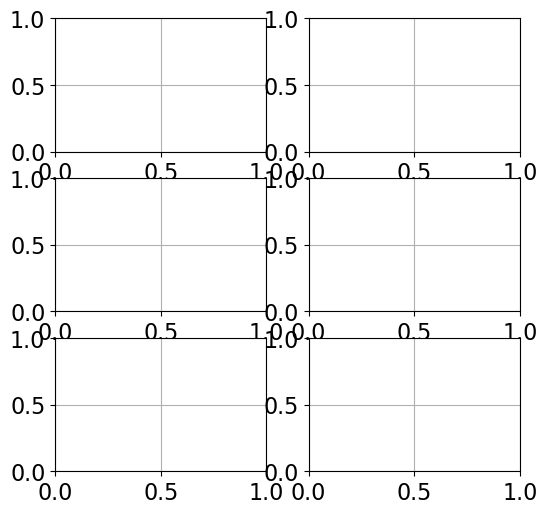

In [16]:
# here is how you would plot one flat
# you should edit this to do all of them in a loop

#fig, ax = plt.subplots(6, 1, figsize=(6, 6))
#show_image(flat.data[:,c0:c1], cmap='gray', ax=ax, fig=fig)
#ax.set_title(v_files[i][-9:]+', V') # index filename to exclude long directory
#plt.tight_layout()
#plt.show()
#print(v_files[5])
for i in range(np.size(v_files)):

    flat = CCDData.read(v_files[i],unit='adu') # this is how CCDPROC reads in one fits image\
    
    fig, (ax1,ax2,ax3) = plt.subplots(3, 2, figsize=(6, 6))
    show_image(flat.data[:,c0:c1], cmap='gray', ax=ax1, fig=fig)
    ax.set_title(v_files[-9:]+', V') # index filename to exclude long directory
    plt.tight_layout()
    plt.show()

In [ ]:
# get obs times, try looking for the 'date-obs' header keyword
times = imgs.filter(imagetyp='skyflat',filter='V').summary['date-obs'].data.data 
flat_times = [datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.%f') for time in times] # these are nicely formatted for plotting

# get the average level in each frame
# use list comprehension to make an array of the V-band flat mean values
# it should have the same length as the flat_tiles variable above
# here are the steps to do this for only the first flat
file_name = v_files[0]
one_flat  = CCDData.read(file_name,unit='adu') # this is CCDPROC's way of reading in fits files
one_mn    = np.mean(one_flat.data)

flat_mn = np.ones_like(flat_times)*one_mn # dummy variable for array of V-band flat mean values

# make the plot
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(flat_times,flat_mn,'red',marker='o',ls='')
ax.set_xlabel(r'Time',fontsize=22)
ax.set_ylabel(r'Counts',fontsize=22)
fig.suptitle('Average flat level in V', fontsize=22)
fig.tight_layout()
plt.show()

In [ ]:
# get obs times, try looking for the 'date-obs' header keyword
times = imgs.filter(imagetyp='skyflat',filter='V').summary['date-obs'].data.data 
flat_times = [datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.%f') for time in times] # these are nicely formatted for plotting


for i in range(np.size(v_files)):
    file_name = v_files[i]
    flat  = CCDData.read(file_name,unit='adu') # this is CCDPROC's way of reading in fits files
    mn    = np.mean(one_flat.data)

    flat_mn = np.ones_like(flat_times)*one_mn # dummy variable for array of V-band flat mean values

# make the plot
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(flat_times,flat_mn,'red',marker='o',ls='')
    ax.set_xlabel(r'Time',fontsize=22)
    ax.set_ylabel(r'Counts',fontsize=22)
    fig.suptitle('Average flat level in V', fontsize=22)
    fig.tight_layout()
    plt.show()

In [ ]:
# you can do this with CCDPROC's combine function:
flat_mn_ccdp = ccdp.combine(v_files,method='average',unit='adu',sigma_clip=False)

# or you can read in the data and do the combine yourself
flats   = [CCDData.read(file_name,unit='adu').data for file_name in v_files]
flat_mn = np.mean(flats,axis=0)   # is that the right number for axis?

In [ ]:
# now plot them
# the titles are suggestions for flats you may want to compare
# you will need to edit the input data arrays, these are mostly placeholders
# try taking the the ccdp-numpy mean flats to see if they are different
fig, (ax1,ax2) = plt.subplots(2, 2, figsize=(20, 20))
show_image(flat_mn_ccdp.data[:,c0:c1], cmap='gray', ax=ax1[0], fig=fig)
ax1[0].set_title('Mean (ccdp)')
show_image(flat_mn[:,c0:c1], cmap='gray', ax=ax1[1], fig=fig)
ax1[1].set_title('Mean (numpy)')
show_image(flat_mn_ccdp.data[:,c0:c1], cmap='gray', ax=ax2[0], fig=fig)
ax2[0].set_title('Median (ccdp)')
show_image(flat_mn[:,c0:c1], cmap='gray', ax=ax2[1], fig=fig)
ax2[1].set_title('Individual V flat')
plt.tight_layout()
plt.show()

In [ ]:
# define your own functions that tell CCDPROC how to scale your images
def inv_median(x):
    return 1./np.median(x)

def inv_mean(x):
    return 1./np.mean(x)

def inv_mode(x):
    return 1./stats.mode(x,axis=None)[0][0]

In [ ]:
# you can do this with CCDPROC's combine function:
# this will do a mean combine with mean scaling
flat_md_md_ccdp = ccdp.combine(v_files,method='median',scale=inv_median,unit='adu',sigma_clip=False)

# or you can read in the data and do the combine yourself
flats  = [CCDData.read(file_name,unit='adu').data for file_name in v_files]
scales = np.median(flats,axis=(1,2)) # calculate a single mean value for each flat
scale_images = np.ones_like(flats)*scales[:,np.newaxis,np.newaxis] # make an images shaped like the flats, where each pixel has the identical scale value in it
scaled_flats = flats/scale_images

flat_md_md = np.median(scaled_flats,axis=0)

In [ ]:
# make plots to show what you're doing
# now plot them
# the titles are suggestions for flats you may want to compare
# you will need to edit the input data arrays, these are mostly placeholders
# try taking the the ccdp-numpy mean flats to see if they are different
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('Median combine')
show_image(flat_md_md[:,c0:c1], cmap='gray', ax=ax[0], fig=fig)
ax[1].set_title('Median scale, median combine')
show_image(flat_md_md[:,c0:c1], cmap='gray', ax=ax[1], fig=fig)
fig.suptitle('Effect of scaling',size=28)
plt.tight_layout()
plt.show()

In [ ]:
# you can do this with CCDPROC's combine function:
# this will do a mean combine with mean scaling
flat_mn_mn_ccdp = ccdp.combine(v_files,method='average',scale=inv_mean,unit='adu',sigma_clip=False)

# or you can read in the data and do the combine yourself
flats  = [CCDData.read(file_name,unit='adu').data for file_name in v_files]
scales = np.mean(flats,axis=(1,2)) # calculate a single mean value for each flat
scale_images = np.ones_like(flats)*scales[:,np.newaxis,np.newaxis] # make an images shaped like the flats, where each pixel has the identical scale value in it
scaled_flats = flats/scale_images

flat_mn_mn = np.mean(scaled_flats,axis=0)

In [ ]:
# make plots to show what you're doing
# now plot them
# the titles are suggestions for flats you may want to compare
# you will need to edit the input data arrays, these are mostly placeholders
# try taking the the ccdp-numpy mean flats to see if they are different
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('Mean combine')
show_image(flat_mn_mn[:,c0:c1], cmap='gray', ax=ax[0], fig=fig)
ax[1].set_title('Mean scale, median combine')
show_image(flat_mn_mn[:,c0:c1], cmap='gray', ax=ax[1], fig=fig)
fig.suptitle('Effect of scaling',size=28)
plt.tight_layout()
plt.show()